In [15]:
#import torch # this first torch import is CRUCIAL for finding the libtorch files!
import numpy as np
import pynbody as pn
import matplotlib.pyplot as plt

from sph_lib.deposition import (compute_hsm, 
                                compute_hsm_tensor, 
                                project_hsm_tensor_to_2d, 
                                p2g
                                )

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [16]:
import pickle
with open('../../data/dataset_cosmo_2d.pkl', 'rb') as f:
    data = pickle.load(f)

In [17]:
data.keys()
pos = data['pos']
mass = data['mass'][:, np.newaxis]
boxsize = data['boxsize']

In [18]:
grid = p2g(pos,
            mass,
            averaged=[False],
            gridnum=50,
            extent=[0, boxsize],
            periodic=1,
			num_nn=8,
            method='ngp',
            accelerator='cpp'
            )

In [19]:
grid.shape

torch.Size([50, 50, 1])

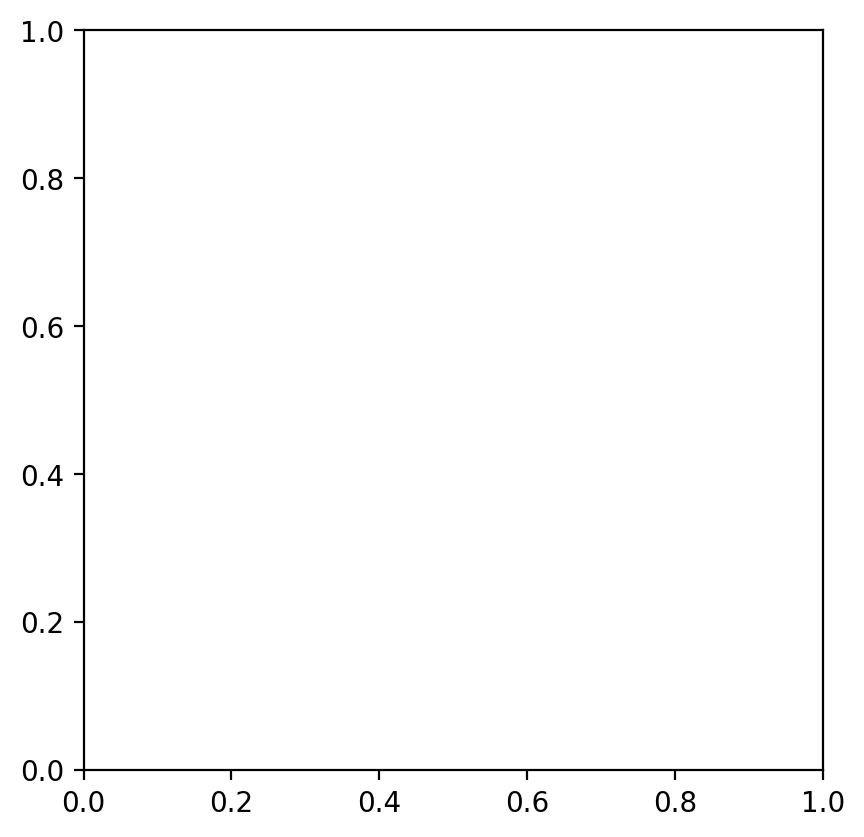

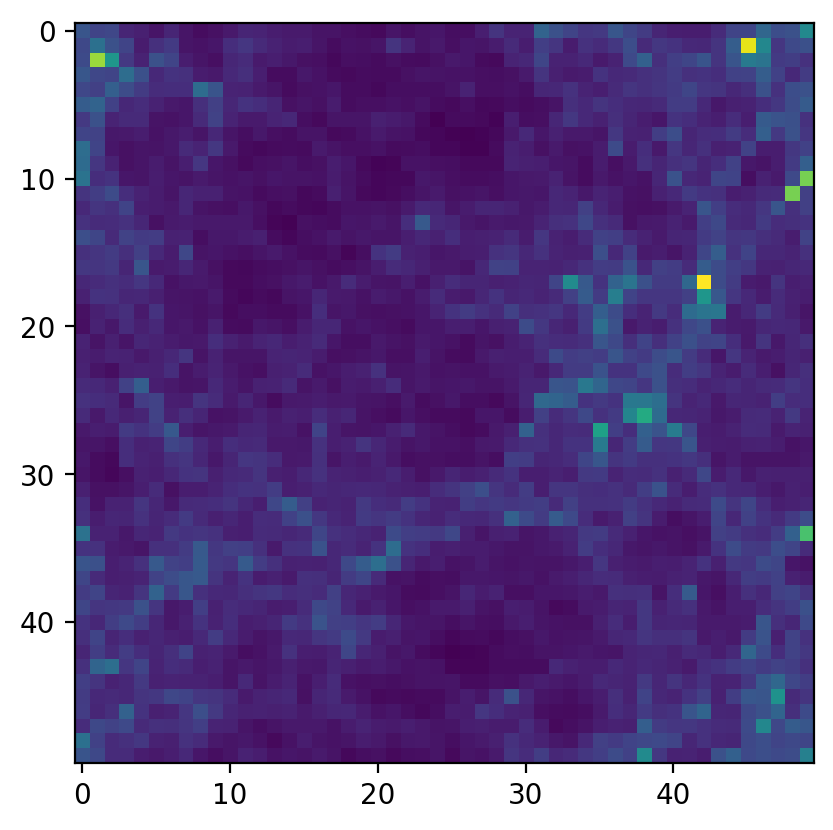

In [20]:
plt.figure()
plt.imshow(grid[..., 0])
plt.show()

In [21]:
ds = pn.load('../../data/snapshot_176_128.hdf5')

In [22]:
# simulation information
periodic = True
boxsize  = 15000
extent   = np.array([0, boxsize])

# grid information
NN       = 8
gridnum  = 50

In [23]:
# needed fields
pos      = ds.gas['pos']
masses   = ds.gas['mass']
temp     = ds.gas['temp']
metals   = ds.gas['metals'][:, 0]

# IMPORTANT: hsm (tensor) needs to be computed from the 3d distribution (unless the simulation is 2d)!!
hsm = compute_hsm(pos, NN, boxsize)[0]
hmat, eλ, ev = compute_hsm_tensor(pos, masses, NN, boxsize)

# stack all quantities to deposit
quantities = np.stack([masses, metals, temp], axis=-1); print(quantities.shape)

# do we need to average the deposited quantities or not?
averaged   = [False, True, True]

(2087272, 3)


#### 2D case

In [24]:
mask = np.logical_and(pos[:, -1] > 0,
                      pos[:, -1] < 3000)

pos_masked          = pos[mask][:, :2]
masses_masked       = masses[mask]
hsm_masked          = hsm[mask]
hmat_masked        = hmat[mask]
quantities_masked   = quantities[mask]
hmat_2d, eλ_2d, ev_2d = project_hsm_tensor_to_2d(hmat_masked, plane=(0, 1)) 

kwargs = {'positions': pos_masked, 
          'quantities': quantities_masked, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [25]:
fields_ngp = p2g(**kwargs, method='ngp')
fields_cic = p2g(**kwargs, method='cic')
fields_tsc = p2g(**kwargs, method='tsc')

fields_ngp_cpp = p2g(**kwargs, method='ngp', accelerator='cpp')
fields_cic_cpp = p2g(**kwargs, method='cic', accelerator='cpp')
fields_tsc_cpp = p2g(**kwargs, method='tsc', accelerator='cpp')

fields_cic_ada_cpp = p2g(**kwargs, method='cic_adaptive', accelerator='cpp', num_nn=NN)
fields_tsc_ada_cpp = p2g(**kwargs, method='tsc_adaptive', accelerator='cpp', num_nn=NN)

fields_sph_iso_cpp_1   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='gaussian')
fields_sph_iso_cpp_2   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='super_gaussian')
fields_sph_iso_cpp_3   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='cubic')
fields_sph_iso_cpp_4   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='quintic')
fields_sph_iso_cpp_5   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c2')
fields_sph_iso_cpp_6   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c4')
fields_sph_iso_cpp_7   = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c6')

fields_sph_aniso_cpp_1 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='gaussian')
fields_sph_aniso_cpp_2 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='super_gaussian')
fields_sph_aniso_cpp_3 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='cubic')
fields_sph_aniso_cpp_4 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='quintic')
fields_sph_aniso_cpp_5 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='wendland_c2')
fields_sph_aniso_cpp_6 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='wendland_c4')
fields_sph_aniso_cpp_7 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvals=eλ_2d, hmat_eigvecs=ev_2d, kernel_name='wendland_c6')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
fig, ax = plt.subplots(8, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_ngp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_cic)[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_tsc)[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_ngp_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_cic_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_cic_ada_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_tsc_cpp)[:, :, i])

for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_tsc_ada_cpp)[:, :, i])
plt.show()

In [ ]:
fig, ax = plt.subplots(14, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_sph_iso_cpp_1)[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2)[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_sph_iso_cpp_3)[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_sph_iso_cpp_4)[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_sph_iso_cpp_5)[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_sph_iso_cpp_6)[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_sph_iso_cpp_7)[:, :, i])


for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_sph_aniso_cpp_1)[:, :, i])

for i in range(quantities.shape[1]):
    ax[8, i].imshow(np.log10(fields_sph_aniso_cpp_2)[:, :, i])

for i in range(quantities.shape[1]):
    ax[9, i].imshow(np.log10(fields_sph_aniso_cpp_3)[:, :, i])

for i in range(quantities.shape[1]):
    ax[10, i].imshow(np.log10(fields_sph_aniso_cpp_4)[:, :, i])

for i in range(quantities.shape[1]):
    ax[11, i].imshow(np.log10(fields_sph_aniso_cpp_5)[:, :, i])

for i in range(quantities.shape[1]):
    ax[12, i].imshow(np.log10(fields_sph_aniso_cpp_6)[:, :, i])

for i in range(quantities.shape[1]):
    ax[13, i].imshow(np.log10(fields_sph_aniso_cpp_7)[:, :, i])
plt.show()

#### 3D case

In [ ]:
kwargs = {'positions': pos, 
          'quantities': quantities, 
          'averaged': averaged, 
          'extent': extent, 
          'gridnum': gridnum, 
          'periodic': 1}

In [ ]:
fields_ngp = p2g(**kwargs, method='ngp')
fields_cic = p2g(**kwargs, method='cic')
fields_tsc = p2g(**kwargs, method='tsc')

fields_ngp_cpp = p2g(**kwargs, method='ngp', accelerator='cpp')
fields_cic_cpp = p2g(**kwargs, method='cic', accelerator='cpp')
fields_tsc_cpp = p2g(**kwargs, method='tsc', accelerator='cpp')

fields_cic_ada_cpp = p2g(**kwargs, method='cic_adaptive', accelerator='cpp', num_nn=NN)
fields_tsc_ada_cpp = p2g(**kwargs, method='tsc_adaptive', accelerator='cpp', num_nn=NN)

fields_sph_iso_cpp_1 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='gaussian')
fields_sph_iso_cpp_2 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='super_gaussian')
fields_sph_iso_cpp_3 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='cubic')
fields_sph_iso_cpp_4 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='quintic')
fields_sph_iso_cpp_5 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c2')
fields_sph_iso_cpp_6 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c4')
fields_sph_iso_cpp_7 = p2g(**kwargs, method='sph_isotropic', accelerator='cpp', hsm=hsm, kernel_name='wendland_c6')

fields_sph_aniso_cpp_1 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='gaussian')
fields_sph_aniso_cpp_2 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='super_gaussian')
fields_sph_aniso_cpp_3 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='cubic')
fields_sph_aniso_cpp_4 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='quintic')
fields_sph_aniso_cpp_5 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c2')
fields_sph_aniso_cpp_6 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c4')
fields_sph_aniso_cpp_7 = p2g(**kwargs, method='sph_anisotropic', accelerator='cpp', hmat_eigvecs=ev, hmat_eigvals=eλ, kernel_name='wendland_c6')

In [ ]:
fig, ax = plt.subplots(8, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_ngp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_cic.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_tsc.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_ngp_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_cic_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_cic_ada_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_tsc_cpp.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_tsc_ada_cpp.mean(axis=0))[:, :, i])

plt.show()

In [ ]:
fig, ax = plt.subplots(14, quantities.shape[1], figsize=(16, 72))
for i in range(quantities.shape[1]):
    ax[0, i].imshow(np.log10(fields_sph_iso_cpp_1.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[1, i].imshow(np.log10(fields_sph_iso_cpp_2.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[2, i].imshow(np.log10(fields_sph_iso_cpp_3.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[3, i].imshow(np.log10(fields_sph_iso_cpp_4.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[4, i].imshow(np.log10(fields_sph_iso_cpp_5.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[5, i].imshow(np.log10(fields_sph_iso_cpp_6.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[6, i].imshow(np.log10(fields_sph_iso_cpp_7.mean(axis=0))[:, :, i])


for i in range(quantities.shape[1]):
    ax[7, i].imshow(np.log10(fields_sph_aniso_cpp_1.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[8, i].imshow(np.log10(fields_sph_aniso_cpp_2.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[9, i].imshow(np.log10(fields_sph_aniso_cpp_3.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[10, i].imshow(np.log10(fields_sph_aniso_cpp_4.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[11, i].imshow(np.log10(fields_sph_aniso_cpp_5.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[12, i].imshow(np.log10(fields_sph_aniso_cpp_6.mean(axis=0))[:, :, i])

for i in range(quantities.shape[1]):
    ax[13, i].imshow(np.log10(fields_sph_aniso_cpp_7.mean(axis=0))[:, :, i])
plt.show()

In [ ]:
raise SystemExit

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 9))

for j in range(4):
    fov = np.s_[50:150, -100:]

    ax[j, 0].imshow(np.log10(fields[j][fov][...,0]), cmap='bone', vmin=-4)
    ax[j, 1].imshow(fields[j][fov][...,1], cmap='twilight')
    ax[j, 2].imshow(np.log10(fields[j][fov][...,-2]), cmap='binary_r')
    ax[j, 3].imshow(np.log10(fields[j][fov][...,-1]), cmap='gist_heat')

for a in ax.flat:
    a.axis('off')

plt.tight_layout()
fig.savefig('plots/deposition_comparison.png', transparent=True, dpi=300)
plt.show()

We can plot the smoothing ellipses (projected 3d-ellipsoids to the plane) compared to the isotropic smoothing lengths (circles)

In [ ]:
from matplotlib.patches import Circle, Ellipse

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], s=1, ec='none', alpha=0.5)

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='k', lw=1, alpha=0.5)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle):
    ellipse = Ellipse(center, width, height, angle=angle, 
                      fill=False, edgecolor='g', lw=1, alpha=0.8)
    ax.add_patch(ellipse)


for p, h, w, v in zip(pos[::250], 
                      hsm[::250], 
                      eλ_2d[::250], 
                      ev_2d[::250]):

    # Calculate width, height, and angle of the ellipse
    width, height = 2*w
    angle = np.degrees(np.arctan2(*v[:, 0][::-1]))

    # Draw the smoothing circle and ellipse
    center = (p[0], p[1])
    draw_circle(ax, center, h)
    draw_ellipse(ax, center, width, height, angle)
    